In [1]:
# from apex import amp
import numpy as np # linear algebra
import pandas as pd
import os, cv2, gc
from PIL import Image
from torch.utils.data import Dataset, DataLoader, DistributedSampler
import torch, torchvision
from torch import nn, optim
import kornia as K
from torchvision import transforms
from torch import tensor
from functools import partial

import sys, random, cv2
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt
import torch.nn.functional as F

sys.path.append('../input/image-utils')
from optimizers import *
import scipy as sp
import functools, time
import itertools

In [2]:
df = pd.read_csv('../input/prostate-cancer-grade-assessment/train.csv')
df['data_provider'] = df['data_provider'].replace({'karolinska':0, 'radboud':1})

In [3]:
def create_folds(n):
    kfs = StratifiedKFold(n)
    dist_train, dist_valid = [], []
    for fold, (train_ids, valid_ids) in enumerate(kfs.split(df['image_id'], df['isup_grade'])):
        train, valid = df.iloc[train_ids, :], df.iloc[valid_ids, :]
        dist_train.append(train['isup_grade'].value_counts().values)
        dist_valid.append(valid['isup_grade'].value_counts().values)
        train.to_pickle(f'../working/train_{fold}.pkl')
        valid.to_pickle(f'../working/valid_{fold}.pkl')
    return np.vstack(dist_train), np.vstack(dist_valid)

create_folds(5)

(array([[2313, 2133, 1074,  999,  994,  979],
        [2313, 2132, 1075, 1000,  994,  979],
        [2314, 2133, 1075,  999,  993,  979],
        [2314, 2133, 1074,  999,  993,  980],
        [2314, 2133, 1074,  999,  994,  979]]),
 array([[579, 533, 269, 250, 248, 245],
        [579, 534, 268, 249, 248, 245],
        [578, 533, 268, 250, 249, 245],
        [578, 533, 269, 250, 249, 244],
        [578, 533, 269, 250, 248, 245]]))

In [4]:
N = 12
sz= 128
mean = torch.tensor([1-0.81, 1-0.610, 1-0.738])
std = torch.tensor([0.405, 0.512, 0.418])

def rgb2tensor(x):
    x = np.moveaxis(x, -1, 0)
    x = np.ascontiguousarray(x)
    return torch.from_numpy(x/255.)

def get_tiles(f):
    imgs = []
    for i in range(N):
        imgs.append(rgb2tensor(cv2.cvtColor(~cv2.imread(f'../input/panda-dataset-x2/{f}_{i}.png'), cv2.COLOR_BGR2RGB)))
    return torch.stack(imgs)

In [5]:
class ToBatches():
    def __call__(self, x):
        return x.view(-1, N, 3, sz, sz)
    
class squeezed():
    def __call__(self, x):
        return x.view(-1, 3, sz, sz)

In [6]:
train_aug = transforms.Compose([
                          squeezed(),  
                          K.augmentation.RandomAffine(20, shear= (-5, 5), scale=(0.95, 1.1)),
                          K.augmentation.RandomHorizontalFlip(p=0.3),
                          K.augmentation.RandomVerticalFlip(p=0.3),
#                           K.augmentation.RandomMotionBlur(5, (0, 15), 20, 1),
                          K.augmentation.RandomPerspective(0.2, 0.2),  
                          ToBatches()  
                    ])

aug2img = transforms.Compose([
                              K.tensor_to_image])


aug2img2 = transforms.Compose([
    K.augmentation.Denormalize(mean, std),
                              K.tensor_to_image])

primary_tfms = transforms.Compose([K.augmentation.Normalize(mean, std)])

In [7]:
class PandaDataset(Dataset):
    def __init__(self, df):
        self.image_id = df.image_id.values
        self.targs = df['isup_grade'].values
        
    def __getitem__(self, idx):
        return primary_tfms(get_tiles(self.image_id[idx])), torch.tensor(self.targs[idx], dtype=torch.float32)
    
    def __len__(self):
        return len(self.image_id)

In [8]:
ds = PandaDataset(df)
dl = DataLoader(ds, batch_size=10, shuffle=True)

In [9]:
t = next(iter(dl))[0]

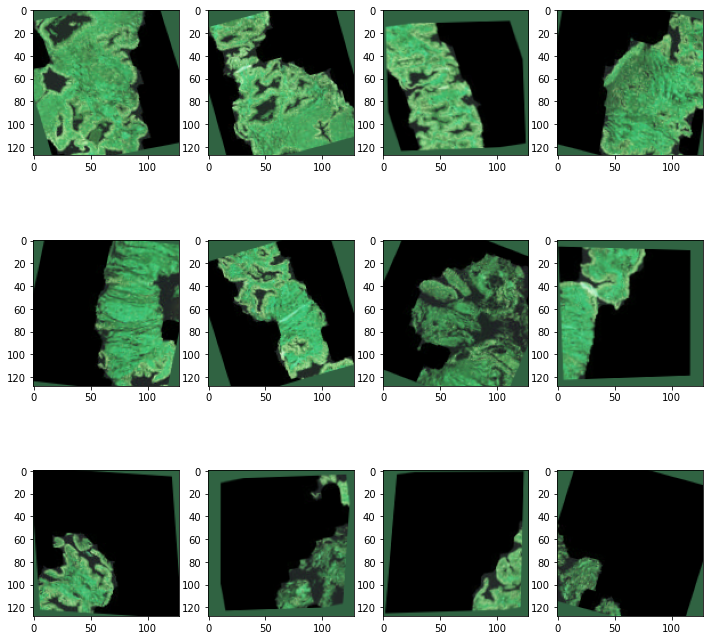

In [10]:
fig, axes = plt.subplots(3, 4, figsize=(12, 12))

t1 = train_aug(t)[0]
for k, ax in enumerate(axes.ravel()):
    ax.imshow(aug2img2(t1[k]))

In [11]:
def get_base():
    model = torchvision.models.resnet34(pretrained=True)
    return model

In [12]:
def set_grad(m, b=False):
    if isinstance(m, (nn.Linear, nn.BatchNorm2d)): return
    if hasattr(m, 'weight'):
        for n, p in m.named_parameters():
            p.requires_grad_(b)

In [13]:
class Mish(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x*(torch.tanh(F.softplus(x)))

def to_Mish(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, Mish())
        else:
            to_Mish(child)

In [14]:
class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=1):
        super().__init__()
        self.output_size = sz
        self.ap = nn.AdaptiveAvgPool2d(sz)
        self.mp = nn.AdaptiveMaxPool2d(sz)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

In [15]:
class OptimizedRounder():
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 4
            else:
                X_p[i] = 5

        ll = calc_score(y, X_p)
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5, 4.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 4
            else:
                X_p[i] = 5
        return X_p

    def coefficients(self):
        return self.coef_['x']
    
optimized_rounder = OptimizedRounder()
loss_fn = nn.SmoothL1Loss()

In [16]:
def calc_score(y1, y2):
    return cohen_kappa_score(y1, y2, weights='quadratic')

def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

In [17]:
def get_dl(df, bs= 8):
    ds = PandaDataset(df)
    return DataLoader(ds,shuffle=True, batch_size=bs, num_workers=4, pin_memory=True)

In [18]:
class Model(nn.Module):
    def __init__(self, base, n=6):
        super().__init__()
        m = base
        self.enc = nn.Sequential(*list(m.children())[:-2])       
        nc = list(m.children())[-1].in_features
        self.head = nn.Sequential(AdaptiveConcatPool2d(), nn.Flatten(),nn.Linear(2*nc,512),
                            Mish(),nn.BatchNorm1d(512), nn.Dropout(0.5),nn.Linear(512,n))
        
    def forward(self, x):
        n = x.shape[1]
        y1 = self.enc(x.view(-1, 3, sz, sz))
        s = y1.shape
        y1 = y1.view(-1,n,s[1],s[2],s[3]).permute(0,2,1,3,4).contiguous()\
          .view(-1,s[1],s[2]*n,s[3])
        return self.head(y1)

In [19]:
def timer(f):
    @functools.wraps(f)
    def wrap_timer(*args, **kwargs):
        start_time = time.perf_counter()
        val = f(*args, **kwargs)
        end_time = time.perf_counter()
        run_time = end_time - start_time
        print(f'Time elapsed : {int(run_time//60)}m {run_time%60:.2f}s', end= " "*30+'\n')
        return val
    return wrap_timer

In [20]:
def get_progress(idx, l, width=50, char= '❱', bgd = ' '):
    wrap = int((idx/l)*width)
    cover = width-wrap
    pct = idx*100/l
    return f'{char*wrap}{bgd*cover}|| {pct:.2f} %'

def start_timer():
    x1 = time.time()
    def _inner():
        return time.time()-x1
    return _inner

In [21]:
@timer
def train_loop(dl, model, opt, scheduler, device):
    loss_acc, acc_acc = 0.0, 0.0
    preds_acc, valid_labels = [], []
    opt_rounder_train = OptimizedRounder()
    l = len(dl)
    model.train()
    for bi, (xb, yb) in enumerate(dl):
        xb, yb = xb.to(device), yb.to(device)
        preds = model(train_aug(xb).float())
        loss = loss_fn(preds.view(-1), yb)
        loss.backward()
        torch.nn.utils.clip_grad_value_(model.parameters(), 1.0)
        opt.step()
        scheduler.step()
        opt.zero_grad()
        loss_acc += loss.item()
        preds_acc.append(preds.detach().to('cpu').numpy())
        valid_labels.append(yb.detach().to('cpu').numpy())
        print(f'\rtrain metric: {get_progress(bi, l)}, loss: {(loss_acc/(bi+1)):.4f} ↓', end='', file=sys.stdout, flush=True)
        
    preds = np.concatenate(preds_acc)
    valid_labels = np.concatenate(valid_labels)
    opt_rounder_train.fit(preds, valid_labels)
    coefficients = opt_rounder_train.coefficients()
    final_preds = opt_rounder_train.predict(preds, coefficients)
    score = calc_score(valid_labels, final_preds)
    print(f'\rtrain_metrics loss: {loss_acc/(bi+1):.5f}, score: {score:.5f}', end = ' ')

In [22]:
@timer
def valid_loop(dl, model, device):
    loss_acc = 0.0
    preds_acc, valid_labels = [], []
    l=len(dl)
    model.eval()
    with torch.no_grad():
        for bi, (xb, yb) in enumerate(dl):
            xb, yb = xb.to(device), yb.to(device)
            s = xb.shape
            preds = model(xb.float())
            loss = loss_fn(preds.view(-1), yb)
            loss_acc += loss.item()
            preds_acc.append(preds.detach().to('cpu').numpy())
            valid_labels.append(yb.detach().to('cpu').numpy())
            print(f'\rvalid metric: {get_progress(bi, l)}, loss: {(loss_acc/(bi+1)):.4f}', end='', file=sys.stdout, flush=True)
            
    preds = np.concatenate(preds_acc)
    valid_labels = np.concatenate(valid_labels)
    optimized_rounder.fit(preds, valid_labels)
    coefficients = optimized_rounder.coefficients()
    final_preds = optimized_rounder.predict(preds, coefficients)
    score = calc_score(valid_labels, final_preds)
    print(f'\rvalid_metrics: loss: {loss_acc/(bi+1):.5f}, score: {score:.5f}', end = ' ')
    return score

In [23]:
BN_TYPES = (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d,)
LIN_TYPES = (nn.Linear)

def freeze_to(m, n:int, skip_groups=None):
    assert n < n_children(m), 'the parameters to freeze greater than number of parameters'
    skip_groups = BN_TYPES if skip_groups==None else BN_TYPES+(skip_groups)
    for i, (name, c) in enumerate(m.named_children()):
        if i<n:
            getattr(m, name).apply(partial(set_grad, b=False, skip_groups=skip_groups))

def unfreeze(m):
    for p in m.parameters():
        p.requires_grad_(True)

def n_children(m):
    return len(list(m.children()))

def freeze(m):
    freeze_to(m, n_children(m))

def count_parameters(m: nn.Module):
    total = int(sum(p.numel() for p in m.parameters()))
    trainable = int(sum(p.numel() for p in m.parameters() if p.requires_grad))
    return f'total :{total}, trainable :{trainable}'

def set_grad(m, b, skip_groups=None, **kwargs):
    if isinstance(m, skip_groups):
        return
    if hasattr(m, 'weight'):
        for n, p in m.named_parameters():
            p.requires_grad_(b)

def get_param_dict(m, lr:tuple, n: int):
    params, lrs = [], []
    for i, (_name, c) in enumerate(m.named_children()):
        for p in getattr(m, _name).parameters():
            if p.requires_grad:
                if i < n:
                    params.append({'params': p, 'lr': lr[0]})
                    lrs.append(lr[0])
                else:
                    params.append({'params': p, 'lr': lr[1]})
                    lrs.append(lr[1])
    return params, lrs

In [24]:
def run(fold):
    trains, vals = pd.read_pickle(f'../working/train_{fold}.pkl'), pd.read_pickle(f'../working/valid_{fold}.pkl')
    model = Model(get_base(), 1)
    device = 'cuda'
    model.to(device)
    freeze_to(model, 1)
    print(count_parameters(model))
    opt = optim.Adam(model.parameters(), lr=0.001)
    num_steps = int(trains.shape[0]/32)+1
    acc_score = -100
    
    scheduler = optim.lr_scheduler.OneCycleLR(opt,max_lr=5e-3, steps_per_epoch=num_steps, epochs=3, final_div_factor=500)
    for epoch in range(16):
        print(f'epoch {epoch+1}')
        if epoch == 3:
            unfreeze(model)
            params_dict, lrs = get_param_dict(model, (5e-5, 1e-4), 1)
            opt =  optim.Adam(params_dict)
            print('# parameters after unfreezing, ', count_parameters(model))
            scheduler = optim.lr_scheduler.OneCycleLR(opt, max_lr=lrs, steps_per_epoch=num_steps, epochs=13, final_div_factor=500, pct_start=0.0)
        train_loop(get_dl(trains, 32), model, opt, scheduler, device)
        val_score = valid_loop(get_dl(vals, 32), model, device)
        if val_score>acc_score:
            torch.save(model.state_dict(), f"../working/model_{fold}.pth")
            print(f'the val_metrics increased to {acc_score}-->{val_score}\n')
            acc_score = val_score

In [25]:
run(0)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth



total :21811009, trainable :543361
epoch 1
train_metrics loss: 1.00629, score: 0.38926 Time elapsed : 3m 25.87s                              
valid_metrics: loss: 1.15920, score: 0.57310 Time elapsed : 0m 50.26s                              
the val_metrics increased to -100-->0.5731003142240676

epoch 2
train_metrics loss: 0.62430, score: 0.64518 Time elapsed : 2m 56.83s                              
valid_metrics: loss: 0.90328, score: 0.56981 Time elapsed : 0m 43.24s                              
epoch 3
train_metrics loss: 0.54429, score: 0.69720 Time elapsed : 3m 0.13s                              
valid_metrics: loss: 0.79860, score: 0.69028 Time elapsed : 0m 45.91s                              
the val_metrics increased to 0.5731003142240676-->0.6902797553093888

epoch 4
# parameters after unfreezing,  total :21811009, trainable :21811009
train_metrics loss: 0.54283, score: 0.69528 Time elapsed : 3m 9.66s                              
valid_metrics: loss: 0.53865, score: 0.7607

In [26]:
run(1)

total :21811009, trainable :543361
epoch 1
train_metrics loss: 0.96589, score: 0.44893 Time elapsed : 3m 11.18s                              
valid_metrics: loss: 1.09166, score: 0.60551 Time elapsed : 0m 48.58s                              
the val_metrics increased to -100-->0.6055089687692481

epoch 2
train_metrics loss: 0.60780, score: 0.66282 Time elapsed : 3m 11.18s                              
valid_metrics: loss: 0.88496, score: 0.67688 Time elapsed : 0m 47.85s                              
the val_metrics increased to 0.6055089687692481-->0.6768782862713165

epoch 3
train_metrics loss: 0.53266, score: 0.70444 Time elapsed : 3m 7.68s                              
valid_metrics: loss: 0.72467, score: 0.67104 Time elapsed : 0m 45.36s                              
epoch 4
# parameters after unfreezing,  total :21811009, trainable :21811009
train_metrics loss: 0.52485, score: 0.71353 Time elapsed : 3m 3.21s                              
valid_metrics: loss: 0.97118, score: 0.64043

In [27]:
run(2)

total :21811009, trainable :543361
epoch 1
train_metrics loss: 0.97684, score: 0.43375 Time elapsed : 3m 17.47s                              
valid_metrics: loss: 0.64854, score: 0.63772 Time elapsed : 0m 44.62s                              
the val_metrics increased to -100-->0.637715391099428

epoch 2
train_metrics loss: 0.63474, score: 0.64337 Time elapsed : 3m 8.37s                              
valid_metrics: loss: 1.38756, score: 0.61677 Time elapsed : 0m 46.90s                              
epoch 3
train_metrics loss: 0.54580, score: 0.69807 Time elapsed : 3m 13.44s                              
valid_metrics: loss: 0.88619, score: 0.63408 Time elapsed : 0m 46.67s                              
epoch 4
# parameters after unfreezing,  total :21811009, trainable :21811009
train_metrics loss: 0.54081, score: 0.69772 Time elapsed : 3m 7.56s                              
valid_metrics: loss: 0.76207, score: 0.69561 Time elapsed : 0m 44.97s                              
the val_metrics

In [28]:
run(3)

total :21811009, trainable :543361
epoch 1
train_metrics loss: 0.97198, score: 0.45293 Time elapsed : 3m 18.19s                              
valid_metrics: loss: 1.27234, score: 0.58820 Time elapsed : 0m 48.03s                              
the val_metrics increased to -100-->0.5881986432434447

epoch 2
train_metrics loss: 0.61002, score: 0.66169 Time elapsed : 3m 18.26s                              
valid_metrics: loss: 0.83568, score: 0.65766 Time elapsed : 0m 47.31s                              
the val_metrics increased to 0.5881986432434447-->0.657655488097316

epoch 3
train_metrics loss: 0.53129, score: 0.70586 Time elapsed : 3m 18.85s                              
valid_metrics: loss: 0.81960, score: 0.64435 Time elapsed : 0m 46.26s                              
epoch 4
# parameters after unfreezing,  total :21811009, trainable :21811009
train_metrics loss: 0.52249, score: 0.70995 Time elapsed : 3m 18.01s                              
valid_metrics: loss: 0.88797, score: 0.6738

In [29]:
run(4)

total :21811009, trainable :543361
epoch 1
train_metrics loss: 0.96421, score: 0.44762 Time elapsed : 3m 7.26s                              
valid_metrics: loss: 0.66921, score: 0.62858 Time elapsed : 0m 43.00s                              
the val_metrics increased to -100-->0.6285826691914653

epoch 2
train_metrics loss: 0.61862, score: 0.65273 Time elapsed : 3m 6.89s                              
valid_metrics: loss: 0.90964, score: 0.62960 Time elapsed : 0m 42.65s                              
the val_metrics increased to 0.6285826691914653-->0.6296032720042324

epoch 3
train_metrics loss: 0.54067, score: 0.70292 Time elapsed : 3m 8.52s                              
valid_metrics: loss: 0.71851, score: 0.67158 Time elapsed : 0m 44.14s                              
the val_metrics increased to 0.6296032720042324-->0.6715817071460111

epoch 4
# parameters after unfreezing,  total :21811009, trainable :21811009
train_metrics loss: 0.52807, score: 0.70960 Time elapsed : 3m 6.55s       